# TDX integration in river

## Introduction
Recently, modelling and understanding the change of probability distributions has received attention [5]. This follows the change mining paradigm [1], where the change itself is the subject of study. Recent publications include an approach for quantifying and visualising drift ex-post [2], and an approach for modelling and extrapolating a changing density distribution over time [3]. For the latter, an algorithm named Temporal Density Extrapolation (TDX) based on a dynamic basis approach has recently been proposed in [4].

Modelling and extrapolating densities in a data stream has several use cases:
First, it allows to visualise changes, as done in [2], serving among others the objective of transparency in data stream mining, and explaining changes.
Second, it allows to extrapolate changes, as done in [4]. This allows to anticipate changes, thus might help in faster adaptation, or even anticipative adaptation, for example in situations where labels arrive with delay (verification latency, [6]).
Finally, it allows to differentiate between expected changes and unexpected changes. In the former, the changes follow a pattern that the supervisor of a data stream mining approach is aware of, and therefore are of a lesser concern (e.g., addressable by a planned adaptation). The latter, on the contrary, indicates that an intervention might be necessary (e.g., sudden shift that requires resetting the data stream learner).

We propose an extension of RIVER to accommodate research on this type of problem and approaches.
An important requirement for such an extension is the capability to attach time stamps to instances.
This allows to model trends as functions of time, rather than using instance indices as proxies. Thereby, it overcomes the limitation that instances have to be sampled uniformly over time (equidistant in time), which is unrealistic in some applications.
If such time stamps can not be provided, the index of an instance can be used as a proxy (if the assumption above is justifiable).

As a first approach using this extension, we also provide a re-implementation of TDX in Python for RIVER, as well as data generators that provide data streams with time-stamped instances (currently with single features, but easily extendable to multivariate features).

## Coding example

There are 4 different synthetical data sets available for testing purposes. In this example we will use the *weightdrift* stream. A *weightdrift* stream containing 25000 samples can be generated as follows:

In [1]:
from src.data.weight_drift_stream import WeightDriftStream

datastream = WeightDriftStream(n_samples=25000, n_segments=120, dist_support=[0, 7], seed=1)
print(datastream)


Synthetic data generator

    Name  WeightDriftStream 
    Task  Density estimation
 Samples  25,000            
Features  2                 
  Sparse  False             

Configuration
-------------
   n_samples  25000               
  n_segments  120                 
dist_support  [0, 7]              
        seed  RandomState(MT19937)


It is possible to "loop" over the data just in the same way as described in the river tutorials. Note that TDX data sets currently only consist of exactly two feature vectors (however, the number of features might be extended in future). There is one column containing the time stamp and another column representing the corresponding data value. The time stamp column is of type *float*. In this way the UNIX time format as well as instance numbering can be used to describe the different points in time. It is also important that this column is always named *timestamp* so that the TDX model is later able to differentiate between the two columns.

In [5]:
for x in datastream:
    # Here is where learning takes place
    pass

x    # last data sample


{'timestamp': 0.9916666666666667, 'value': 6.771399055838961}

The TDX model can be learned incrementally. But as training of the model might be computational expensive, the TDX model itself is not updated in every iteration. Instead TDX will cache incoming training instances and the model will be updated when there are enough samples inside the internal cache. In this example the TDX model will be updated every 2500 instances.

In [3]:
from src.tdx.tdx import Tdx
model = Tdx(m=14, bandwidth=0.6, r=5, lambda_reg=2, cache_size=2500, grace_period=2500)

for x in datastream:
    density = model.predict_one(x)
    model.learn_one(x)
    

TDX also supports batch learning.

In [2]:
import math
import pandas as pd
from src.tdx.tdx import Tdx

model = Tdx(m=14, bandwidth=0.6, r=5, lambda_reg=2)

train_idx = range(math.ceil(0.66 * datastream.x.shape[0]))
x_train = datastream.x[train_idx]
t_train = datastream.t[train_idx]

df = pd.DataFrame({'timestamp': t_train, 'value': x_train})
model.learn_many(df)

Tdx (
  m=14
  bandwidth=0.6
  r=5
  lambda_reg=2
  n_start_points=1
  cache_size=1000
  grace_period=1000
  seed=RandomState(MT19937)
  verbose=False
)

The `predict_many` method can be used to predict the density for different spatial locations at different timepoints.

In [15]:
import numpy as np
import pandas as pd

t_test = [0.7, 0.8]
x_grid = np.linspace(np.quantile(datastream.x, 0.01), np.quantile(datastream.x, 0.99), 20)

df = pd.concat((pd.DataFrame({'timestamp': t_test}), pd.DataFrame({'spatial_locations': x_grid})), axis=1)
df.head()


,timestamp,spatial_locations
0,0.7,0.435472
1,0.8,0.769189
2,NaN,1.102906
3,NaN,1.436623
4,NaN,1.770340


This dataframe can be passed as an argument to the `predict_many` method. The first column tells TDX at which time points the predictions should be made. The second column contains the spatial locations that should be used for the density predictions.

The `predict_many` then returns a dataframe as a result. Here in this example the first row contains the predicted densities for t=0.7 and in the second row we find the predictions for t=0.8. The columns represent the predicted density at the different spatial locations.

In [16]:
pred_dens = model.predict_many(df)
pred_dens.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.062198,0.134434,0.213528,0.249164,0.213925,0.137209,0.074449,0.059818,0.094813,0.15399,0.194557,0.188538,0.154127,0.137384,0.160850,0.199594,0.207911,0.166925,0.100720,0.045247
1,0.071605,0.154820,0.245953,0.287001,0.246242,0.156961,0.081127,0.054393,0.075653,0.12019,0.152169,0.149658,0.128128,0.125324,0.158507,0.202495,0.212789,0.171417,0.103612,0.046596


The predicted densities can now be compared with the true densities of the *weightdrift* stream.

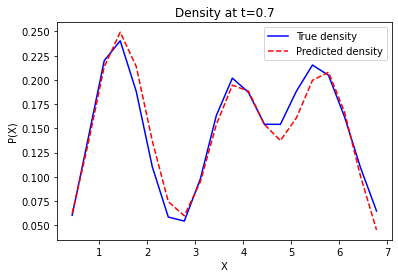

In [17]:
import matplotlib.pyplot as plt

true_dens = datastream.pdf(x_grid, np.array([0.7]))

plt.plot(x_grid, true_dens[0, :], '-b', label="True density")
plt.plot(x_grid, pred_dens.iloc[0, :], '--r', label="Predicted density")
plt.title('Density at t=0.7')
plt.xlabel('X')
plt.ylabel('P(X)')
plt.legend(loc="upper right")

## References
[1] Böttcher, M., Höppner, F., Spiliopoulou, M.: On exploiting the power of time in data mining. ACM SIGKDD Explorations Newsletter 10(2), 3–11 (2008)  
[2] Webb, G., Lee, L.K., Goethals, B., Petitjean, F.: Understanding concept drift. arXiv preprint 1704.00362v1 (2017)  
[3] Krempl, G.: Temporal density extrapolation. In: Douzal-Chouakria, A., Vilar, J.A., Marteau, P.F., Maharaj, A., Alonso, A.M., Otranto, E., Nicolae, M.I. (eds.) Proc. of the 1st Int. Workshop on Advanced Analytics and Learning on Temporal Data (AALTD) co-located with ECML PKDD 2015. vol. 1425. CEUR Workshop Proceedings (2015)  
[4] Krempl, G., Lang, D., Hofer, V.: Temporal density extrapolation using a dynamic basis approach. Data Mining and Knowledge Discovery 33(5), 1323–1356 (2019)  
[5] Krempl, G., Hofer, V., Webb, G., & Hüllermeier, E. (2021). Beyond Adaptation: Understanding Distributional Changes (Dagstuhl Seminar 20372). In Dagstuhl Reports (Vol. 10, No. 4). Schloss Dagstuhl-Leibniz-Zentrum für Informatik.  
[6] Krempl, G., Hofer, V.: Classification in presence of drift and latency. In: Spiliopoulou, M., Wang, H., Cook, D., Pei, J., Wang, W., Zaı̈ane, O., Wu, X. (eds.) Proceedings of the 11th IEEE International Conference on Data Mining Workshops
(ICDMW 2011). IEEE (2011)